# Crawler detection based on sessions
This notebook related to crawler detection with another approach.

## Requirements

In [ ]:
# Import requirements
import re
import pandas as pd
import numpy as np

!pip install pandas-profiling==2.7.1
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

!pip install category_encoders
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

!pip install pyyaml ua-parser user-agents
from user_agents import parse

# Models
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

     |████████████████████████████████| 256kB 5.2MB/s 
     |████████████████████████████████| 1.1MB 38.5MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 3.1MB 22.2MB/s 
     |████████████████████████████████| 296kB 39.7MB/s 
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107437 sha256=bd1073f06d3d1a8cd7df6b9629fc9319bd810842ded9184c5c1c101acd953bdf
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27099 sha256=bdd4cbeeb2609b48a14b45fe52c418bc942395fb4d5a64d6ac18310642208004
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built phik htmlmin
ERROR: phik 0.11.2 has requirement scipy>=1.5.2, but you'll have scipy 1.4.1 which is incompatible.
  Found existing in

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Data Processing

### Extract features from log files to build .csv format


In [ ]:
# Regex Pattern
pattern = '(?P<Client>\S+) \[(?P<Time>\S+)\] \[(?P<Method>\S+) (?P<Request>\S+)\] (?P<Status>\S+) (?P<Size>\S+) \[\[(?P<UserAgent>[\S\s]+)\]\] (?P<Duration>\S+)'
file_path = 'drive/MyDrive/Rahnema-College/Tuning/Final-Project/output.log'
columns = ["Client", "Datetime", "Method", "Request", "Status", "Length", "UserAgent", "ResponseTime"]

In [ ]:
# Find regex in our logs
def parse_data(file_path, pattern):
  """
  Return the part of data that extracted by given pattern.
  file_path -> Your log file.
  pattern -> The pattern that you're looking for in your logs.

  Return parsed_line -> as a list of finded data.
  """
  parsed_lines = []

  with open(file_path) as logs:
    for line in logs:
      try:
        finded_pattern = list(re.findall(pattern, line)[0])
        parsed_lines.append(finded_pattern)
      except Exception as e:
        print("There is an error while parsing data! Try Again :(")
  return parsed_lines

In [ ]:
extracted_features = parse_data(file_path, pattern)
extracted_features[0]

['207.213.193.143',
 '2021-5-12T5:6:0.0+0430',
 'Get',
 '/cdn/profiles/1026106239',
 '304',
 '0',
 'Googlebot-Image/1.0',
 '32']

In [ ]:
# Create a .csv format
data = pd.DataFrame(extracted_features, columns=columns)
data.head()

,Client,Datetime,Method,Request,Status,Length,UserAgent,ResponseTime
0,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,/cdn/profiles/1026106239,304,0,Googlebot-Image/1.0,32
1,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,images/badge.png,304,0,Googlebot-Image/1.0,4
2,35.110.222.153,2021-5-12T5:6:0.0+0430,Get,/pages/630180847,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32
3,35.108.208.99,2021-5-12T5:6:0.0+0430,Get,images/fav_icon2.ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20
4,35.110.222.153,2021-5-12T5:6:0.0+0430,Get,images/sanjagh_logo_purpule5.png,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8


In [ ]:
data.shape

(1260035, 8)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260035 entries, 0 to 1260034
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Client        1260035 non-null  object
 1   Datetime      1260035 non-null  object
 2   Method        1260035 non-null  object
 3   Request       1260035 non-null  object
 4   Status        1260035 non-null  object
 5   Length        1260035 non-null  object
 6   UserAgent     1260035 non-null  object
 7   ResponseTime  1260035 non-null  object
dtypes: object(8)
memory usage: 76.9+ MB


### Fix time series

In [ ]:
# Convert datetimes to datetime format
data["Datetime"] = pd.to_datetime(data["Datetime"], format="%Y-%m-%dT%H:%M:%S")

In [ ]:
# Split datatimes
data['Year'] = data.Datetime.dt.year
data['Month'] = data.Datetime.dt.month
data['Day'] = data.Datetime.dt.day
data['Hour'] = data.Datetime.dt.hour
data['Minute'] = data.Datetime.dt.minute
data['Second'] = data.Datetime.dt.second
data['dayOfWeek'] = data.Datetime.dt.dayofweek
data['dayOfYear'] = data.Datetime.dt.dayofyear

In [ ]:
data.drop("Datetime", axis=1, inplace=True)

In [ ]:
data.head()

,Client,Method,Request,Status,Length,UserAgent,ResponseTime,Year,Month,Day,Hour,Minute,Second,dayOfWeek,dayOfYear
0,207.213.193.143,Get,/cdn/profiles/1026106239,304,0,Googlebot-Image/1.0,32,2021,5,12,5,6,0,2,132
1,207.213.193.143,Get,images/badge.png,304,0,Googlebot-Image/1.0,4,2021,5,12,5,6,0,2,132
2,35.110.222.153,Get,/pages/630180847,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,2021,5,12,5,6,0,2,132
3,35.108.208.99,Get,images/fav_icon2.ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,2021,5,12,5,6,0,2,132
4,35.110.222.153,Get,images/sanjagh_logo_purpule5.png,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,2021,5,12,5,6,0,2,132


### Split Requests
* Level_1
  * Level_2

In [ ]:
path_l1 = []
# paths_pattern = re.compile(r'^(\/|\w+)')
paths_pattern = re.compile(r'\S+\/|\/\S+')
for element in data.Request.values:
  finded_part = paths_pattern.findall(element)
  path_l1.append(finded_part)
path_l1[0]

['/cdn/profiles/']

In [ ]:
# Level Requests' path to make them more categorized
path_l1 = []
path_l2 = []
# paths_pattern = re.compile(r'^(\/|\w+)')
# paths_pattern = re.compile(r'\S+\/|\/\S+|\/')
paths_pattern = re.compile(r'^\/|^\w+\/')
for element in data.Request.values:
  finded_part = paths_pattern.findall(element)[0]
  path_l1.append(finded_part)
  path_l2.append(element.replace(finded_part, "", 1))

data["Req_Path_L1"] = path_l1
data["Req_Path_L2"] = path_l2

In [ ]:
data.head()

,Client,Method,Request,Status,Length,UserAgent,ResponseTime,Year,Month,Day,Hour,Minute,Second,dayOfWeek,dayOfYear,Req_Path_L1,Req_Path_L2
0,207.213.193.143,Get,/cdn/profiles/1026106239,304,0,Googlebot-Image/1.0,32,2021,5,12,5,6,0,2,132,/,cdn/profiles/1026106239
1,207.213.193.143,Get,images/badge.png,304,0,Googlebot-Image/1.0,4,2021,5,12,5,6,0,2,132,images/,badge.png
2,35.110.222.153,Get,/pages/630180847,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,2021,5,12,5,6,0,2,132,/,pages/630180847
3,35.108.208.99,Get,images/fav_icon2.ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,2021,5,12,5,6,0,2,132,images/,fav_icon2.ico
4,35.110.222.153,Get,images/sanjagh_logo_purpule5.png,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,2021,5,12,5,6,0,2,132,images/,sanjagh_logo_purpule5.png


In [ ]:
data["Req_Path_L1"].value_counts()

/             663910
images/       298288
js/           125224
fonts/         98485
css/           56303
templates/     17825
Name: Req_Path_L1, dtype: int64

In [ ]:
# Drop full Request Feature
data.drop("Request", axis=1, inplace=True)
data.head()

,Client,Method,Status,Length,UserAgent,ResponseTime,Year,Month,Day,Hour,Minute,Second,dayOfWeek,dayOfYear,Req_Path_L1,Req_Path_L2
0,207.213.193.143,Get,304,0,Googlebot-Image/1.0,32,2021,5,12,5,6,0,2,132,/,cdn/profiles/1026106239
1,207.213.193.143,Get,304,0,Googlebot-Image/1.0,4,2021,5,12,5,6,0,2,132,images/,badge.png
2,35.110.222.153,Get,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,2021,5,12,5,6,0,2,132,/,pages/630180847
3,35.108.208.99,Get,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,2021,5,12,5,6,0,2,132,images/,fav_icon2.ico
4,35.110.222.153,Get,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,2021,5,12,5,6,0,2,132,images/,sanjagh_logo_purpule5.png


### Check Dataset & Fix Missing values


In [ ]:
# # Create a profile report
# profile = ProfileReport(data)
# profile.to_file("drive/MyDrive/Rahnema-College/Tuning/Final-Project/profile_report.html")

In [ ]:
# Remove Constant features
constant_features = ["Year", "Month", "Day", "dayOfWeek", "dayOfYear"]
data.drop(constant_features, axis=1, inplace=True)

* There are some rows which don't have any values for `ResponseTime` and `Clinet` features. -> They must be dropped.
* Take care: some of rows contains `Clients'` value but no `ResponseTime` value. -> Their response time would be zero.

In [ ]:
data[(data["Client"] == '-') & (data["ResponseTime"] == '-')]

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2
25,-,Get,301,169,kube-probe/1.21,-,5,6,1,/,
85,-,Get,301,169,kube-probe/1.21,-,5,6,3,/,
145,-,Get,301,169,kube-probe/1.21,-,5,6,5,/,
175,-,Get,301,169,kube-probe/1.21,-,5,6,7,/,
215,-,Get,301,169,kube-probe/1.21,-,5,6,9,/,
...,...,...,...,...,...,...,...,...,...,...,...
1259779,-,Get,301,169,kube-probe/1.21,-,15,8,51,/,
1259833,-,Get,301,169,kube-probe/1.21,-,15,8,53,/,
1259902,-,Get,301,169,kube-probe/1.21,-,15,8,55,/,
1259951,-,Get,301,169,kube-probe/1.21,-,15,8,57,/,


In [ ]:
data.head()

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2
0,207.213.193.143,Get,304,0,Googlebot-Image/1.0,32,5,6,0,/,cdn/profiles/1026106239
1,207.213.193.143,Get,304,0,Googlebot-Image/1.0,4,5,6,0,images/,badge.png
2,35.110.222.153,Get,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,5,6,0,/,pages/630180847
3,35.108.208.99,Get,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,5,6,0,images/,fav_icon2.ico
4,35.110.222.153,Get,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,5,6,0,images/,sanjagh_logo_purpule5.png


In [ ]:
# Drop server requests
server_req = data.loc[(data["Client"] == '-') & (data["ResponseTime"] == '-')]
data.drop(server_req.index, axis=0, inplace=True)

In [ ]:
data[(data["Client"] != '-') & (data["ResponseTime"] == '-')]

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2
776,20.62.177.11,Get,200,53479,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,5,6,31,/,pros/1993352776
2010,20.62.177.60,Get,200,55330,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,5,7,27,/,pros/1797822247
2708,20.62.177.133,Get,200,20947,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,5,8,4,/,pros/763244865
2866,207.213.193.118,Get,301,169,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,-,5,8,18,/,pages/1939232229
3468,20.62.177.4,Get,200,37060,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,5,8,49,/,pros/2084824811
...,...,...,...,...,...,...,...,...,...,...,...
1257193,20.62.177.11,Get,200,24540,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,15,7,34,/,pros/1644096504
1257986,20.62.177.11,Get,200,36129,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,15,7,59,/,pros/743056796
1258079,20.62.177.161,Get,200,51334,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,15,8,2,/,pros/1177343248
1258456,207.213.207.17,Get,301,169,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,-,15,8,12,/,services/1404674245


In [ ]:
# Fill missing values for ResponseTime with 0
data.loc[(data["Client"] != '-') & (data["ResponseTime"] == '-'), "ResponseTime"] = '0'

In [ ]:
# Convert String to integers
data["Length"] = data["Length"].astype("int64")
data["ResponseTime"] = data["ResponseTime"].astype("int64")

In [ ]:
# Save dataset
data.to_csv("drive/MyDrive/Rahnema-College/Tuning/Final-Project/data.csv", index=False)

In [ ]:
data = pd.read_csv("drive/MyDrive/Rahnema-College/Tuning/Final-Project/data.csv")

In [ ]:
data.drop(data.loc[data.Req_Path_L2.isna()].index, axis=0, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1235970 entries, 0 to 1241944
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Client        1235970 non-null  object
 1   Method        1235970 non-null  object
 2   Status        1235970 non-null  int64 
 3   Length        1235970 non-null  int64 
 4   UserAgent     1235970 non-null  object
 5   ResponseTime  1235970 non-null  int64 
 6   Hour          1235970 non-null  int64 
 7   Minute        1235970 non-null  int64 
 8   Second        1235970 non-null  int64 
 9   Req_Path_L1   1235970 non-null  object
 10  Req_Path_L2   1235970 non-null  object
dtypes: int64(6), object(5)
memory usage: 113.2+ MB


In [ ]:
# Load dataset
data = pd.read_csv("drive/MyDrive/Rahnema-College/Tuning/Final-Project/data.csv")
data.head()

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2
0,207.213.193.143,Get,304,0,Googlebot-Image/1.0,32,5,6,0,/,cdn/profiles/1026106239
1,207.213.193.143,Get,304,0,Googlebot-Image/1.0,4,5,6,0,images/,badge.png
2,35.110.222.153,Get,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,5,6,0,/,pages/630180847
3,35.108.208.99,Get,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,5,6,0,images/,fav_icon2.ico
4,35.110.222.153,Get,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,5,6,0,images/,sanjagh_logo_purpule5.png


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1241945 entries, 0 to 1241944
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Client        1241945 non-null  object
 1   Method        1241945 non-null  object
 2   Status        1241945 non-null  int64 
 3   Length        1241945 non-null  int64 
 4   UserAgent     1241945 non-null  object
 5   ResponseTime  1241945 non-null  int64 
 6   Hour          1241945 non-null  int64 
 7   Minute        1241945 non-null  int64 
 8   Second        1241945 non-null  int64 
 9   Req_Path_L1   1241945 non-null  object
 10  Req_Path_L2   1235970 non-null  object
dtypes: int64(6), object(5)
memory usage: 104.2+ MB


In [ ]:
data.loc[data.Req_Path_L2.isna()]

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2
152,20.117.146.75,Get,307,0,Go-http-client/2.0,4,5,6,6,/,NaN
353,20.92.247.170,Get,307,0,Go-http-client/2.0,8,5,6,13,/,NaN
610,76.212.164.3,Get,307,0,Go-http-client/2.0,0,5,6,24,/,NaN
632,93.113.99.115,Get,307,0,Go-http-client/2.0,12,5,6,25,/,NaN
810,36.67.23.210,Get,307,0,Go-http-client/2.0,12,5,6,36,/,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1240929,20.92.247.170,Get,307,0,Go-http-client/2.0,4,15,8,25,/,NaN
1241067,93.113.99.115,Get,307,0,Go-http-client/2.0,8,15,8,28,/,NaN
1241081,238.129.28.160,Get,307,0,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,4,15,8,29,/,NaN
1241425,60.148.0.167,Get,307,0,Go-http-client/2.0,4,15,8,41,/,NaN


In [ ]:
# Drop local requests
data.drop(data.loc[data.Req_Path_L2.isna()].index, axis=0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1235970 entries, 0 to 1241944
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Client        1235970 non-null  object
 1   Method        1235970 non-null  object
 2   Status        1235970 non-null  int64 
 3   Length        1235970 non-null  int64 
 4   UserAgent     1235970 non-null  object
 5   ResponseTime  1235970 non-null  int64 
 6   Hour          1235970 non-null  int64 
 7   Minute        1235970 non-null  int64 
 8   Second        1235970 non-null  int64 
 9   Req_Path_L1   1235970 non-null  object
 10  Req_Path_L2   1235970 non-null  object
dtypes: int64(6), object(5)
memory usage: 113.2+ MB


### ip & UserAgents

In [ ]:
# Parse UserAgent and extract features
unique_ua = np.unique(data.UserAgent)
user_agent = {'browser':[],
              'os':[],
              'device':[],
              'isBot':[]}
for user in data.UserAgent.values:
  parsed_user = parse(user)
  user_agent['browser'].append(parsed_user.browser.family)
  user_agent['os'].append(parsed_user.os.family)
  user_agent['device'].append(parsed_user.device.family)
  user_agent['isBot'].append(parsed_user.is_bot)

In [ ]:
len(user_agent['browser']), len(user_agent['os']), len(user_agent['device']), len(user_agent['isBot'])

(1235970, 1235970, 1235970, 1235970)

In [ ]:
# Append extracted features to dataset
data['Browser'] = user_agent['browser']
data['OS'] = user_agent['os']
data['Device'] = user_agent['device']
data['isBot'] = user_agent['isBot']

In [ ]:
data.head()

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2,Browser,OS,Device,isBot
0,207.213.193.143,Get,304,0,Googlebot-Image/1.0,32,5,6,0,/,cdn/profiles/1026106239,Googlebot-Image,Other,Spider,True
1,207.213.193.143,Get,304,0,Googlebot-Image/1.0,4,5,6,0,images/,badge.png,Googlebot-Image,Other,Spider,True
2,35.110.222.153,Get,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,5,6,0,/,pages/630180847,Samsung Internet,Android,Samsung SM-J710GN,False
3,35.108.208.99,Get,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,5,6,0,images/,fav_icon2.ico,Chrome Mobile,Android,Huawei CAM-L21,False
4,35.110.222.153,Get,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,5,6,0,images/,sanjagh_logo_purpule5.png,Samsung Internet,Android,Samsung SM-J710GN,False


In [ ]:
# # Split ip address to identify a user
# user_ip = []
# for ip in data.Client.values:
#   fragment_list = ip.split(".")
#   user_ip.append(fragment_list[0] + "." + fragment_list[1])

In [ ]:
# np.unique(user_ip, return_counts=True)

(array(['1.56', '1.66', '1.81', ..., '99.227', '99.239', '99.96'],
       dtype='<U7'), array([   1,    1,    7, ...,  124, 1707,    1]))

In [ ]:
# data["UniqueIp"] = user_ip

In [ ]:
# # Combine ip range and UserAgent which represent a single user for us
# data["User"] = data["UniqueIp"] + "-" + data["UserAgent"]
# data.drop("UniqueIp", axis=1, inplace=True)
# data.head()

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2,User
0,207.213.193.143,Get,304,0,Googlebot-Image/1.0,32,5,6,0,/,cdn/profiles/1026106239,207.213-Googlebot-Image/1.0
1,207.213.193.143,Get,304,0,Googlebot-Image/1.0,4,5,6,0,images/,badge.png,207.213-Googlebot-Image/1.0
2,35.110.222.153,Get,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,5,6,0,/,pages/630180847,35.110-Mozilla/5.0 (Linux; Android 6.0.1; SAMS...
3,35.108.208.99,Get,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,5,6,0,images/,fav_icon2.ico,35.108-Mozilla/5.0 (Linux; Android 6.0; CAM-L2...
4,35.110.222.153,Get,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,5,6,0,images/,sanjagh_logo_purpule5.png,35.110-Mozilla/5.0 (Linux; Android 6.0.1; SAMS...


In [ ]:
# data.User.value_counts()

207.213-Googlebot-Image/1.0                                                                                                                                                                                       132714
207.213-Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.90 Mobile Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)     38331
20.92-sentry/21.4.1 (https://sentry.io)                                                                                                                                                                            23912
207.213-Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.97 Mobile Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)      7436
36.67-Go-http-client/2.0                                                                                                            

In [ ]:
data.Req_Path_L1.value_counts()

/             639845
images/       298288
js/           125224
fonts/         98485
css/           56303
templates/     17825
Name: Req_Path_L1, dtype: int64

### Add some practical features
They're some features which help the model to distinguish a Crawler from a human.  
Crawlers are mostly have these features:
* Access to images
* Access to robots.txt
* More HEAD requests
* More request wiht errors (contains 4xx or 5xx)
* Extract details from `User Agnet` : Browser, OS, Device, isBot
So we add them to our dataset to demonstrate requests in more details. Also they will help us in identifying sessions.

In [ ]:
data.head()

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2,Browser,OS,Device,isBot
0,207.213.193.143,Get,304,0,Googlebot-Image/1.0,32,5,6,0,/,cdn/profiles/1026106239,Googlebot-Image,Other,Spider,True
1,207.213.193.143,Get,304,0,Googlebot-Image/1.0,4,5,6,0,images/,badge.png,Googlebot-Image,Other,Spider,True
2,35.110.222.153,Get,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,5,6,0,/,pages/630180847,Samsung Internet,Android,Samsung SM-J710GN,False
3,35.108.208.99,Get,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,5,6,0,images/,fav_icon2.ico,Chrome Mobile,Android,Huawei CAM-L21,False
4,35.110.222.153,Get,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,5,6,0,images/,sanjagh_logo_purpule5.png,Samsung Internet,Android,Samsung SM-J710GN,False


In [ ]:
# Define a column that tells us whether a request get an image or not
data['isImage'] = data.Req_Path_L1.str.contains("images/")
# Define a column that tells us wheteher a request needs to acces an html file or not
# data['isHTML'] = data.Req_Path_L1.str.contains(".html")
# Define a column which tells us whether a request contains robots.txt or not
data['robotTxt'] = data.Req_Path_L2.str.contains("robots.txt")
# Define a column to say whether the request was with HEAD method or not
data['isHEAD'] = data.Method == "Head"
# Contain errors ?!
data['Status'] = data['Status'].astype('str')
data['ErrorCode'] = data.Status.str.contains("4..") | data.Status.str.contains("5..")

In [ ]:
data.head()

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2,Browser,OS,Device,isBot,isImage,robotTxt,isHEAD,ErrorCode
0,207.213.193.143,Get,304,0,Googlebot-Image/1.0,32,5,6,0,/,cdn/profiles/1026106239,Googlebot-Image,Other,Spider,True,False,False,False,False
1,207.213.193.143,Get,304,0,Googlebot-Image/1.0,4,5,6,0,images/,badge.png,Googlebot-Image,Other,Spider,True,True,False,False,False
2,35.110.222.153,Get,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,5,6,0,/,pages/630180847,Samsung Internet,Android,Samsung SM-J710GN,False,False,False,False,False
3,35.108.208.99,Get,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,5,6,0,images/,fav_icon2.ico,Chrome Mobile,Android,Huawei CAM-L21,False,True,False,False,False
4,35.110.222.153,Get,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,5,6,0,images/,sanjagh_logo_purpule5.png,Samsung Internet,Android,Samsung SM-J710GN,False,True,False,False,False


In [ ]:
# Add distance feature -> says the distance of the request with its previous one in Minute
data['TimeMin'] = (data.Hour * 60) + data.Minute + (data.Second / 60)
data['DistanceTime'] = data.groupby(['UserAgent'])['TimeMin'].transform('diff')

In [ ]:
data['DistanceTime'].fillna(0.0, inplace=True)

In [ ]:
data.isna().sum()

Client          0
Method          0
Status          0
Length          0
UserAgent       0
ResponseTime    0
Hour            0
Minute          0
Second          0
Req_Path_L1     0
Req_Path_L2     0
Browser         0
OS              0
Device          0
isBot           0
isImage         0
robotTxt        0
isHEAD          0
ErrorCode       0
TimeMin         0
DistanceTime    0
dtype: int64

In [ ]:
# Add count feature -> count of reqeusts for a user agent
data['CountOfRequest'] = data.groupby(['UserAgent'])['UserAgent'].transform('count')

In [ ]:
data.head()

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2,Browser,OS,Device,isBot,isImage,robotTxt,isHEAD,ErrorCode,TimeMin,DistanceTime,CountOfRequest
0,207.213.193.143,Get,304,0,Googlebot-Image/1.0,32,5,6,0,/,cdn/profiles/1026106239,Googlebot-Image,Other,Spider,True,False,False,False,False,306.0,0.0,132714
1,207.213.193.143,Get,304,0,Googlebot-Image/1.0,4,5,6,0,images/,badge.png,Googlebot-Image,Other,Spider,True,True,False,False,False,306.0,0.0,132714
2,35.110.222.153,Get,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,5,6,0,/,pages/630180847,Samsung Internet,Android,Samsung SM-J710GN,False,False,False,False,False,306.0,0.0,38
3,35.108.208.99,Get,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,5,6,0,images/,fav_icon2.ico,Chrome Mobile,Android,Huawei CAM-L21,False,True,False,False,False,306.0,0.0,220
4,35.110.222.153,Get,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,5,6,0,images/,sanjagh_logo_purpule5.png,Samsung Internet,Android,Samsung SM-J710GN,False,True,False,False,False,306.0,0.0,38


In [ ]:
# Save Prepared Dataset
data.to_csv("drive/MyDrive/Rahnema-College/Tuning/Final-Project/data_extra_features.csv", index=False)

### Encoding categoricals

In [ ]:
data = pd.read_csv("drive/MyDrive/Rahnema-College/Tuning/Final-Project/data_extra_features.csv")

In [ ]:
data.head()

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2,Browser,OS,Device,isBot,isImage,robotTxt,isHEAD,ErrorCode,TimeMin,DistanceTime,CountOfRequest
0,207.213.193.143,Get,304,0,Googlebot-Image/1.0,32,5,6,0,/,cdn/profiles/1026106239,Googlebot-Image,Other,Spider,True,False,False,False,False,306.0,0.0,132714
1,207.213.193.143,Get,304,0,Googlebot-Image/1.0,4,5,6,0,images/,badge.png,Googlebot-Image,Other,Spider,True,True,False,False,False,306.0,0.0,132714
2,35.110.222.153,Get,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,5,6,0,/,pages/630180847,Samsung Internet,Android,Samsung SM-J710GN,False,False,False,False,False,306.0,0.0,38
3,35.108.208.99,Get,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,5,6,0,images/,fav_icon2.ico,Chrome Mobile,Android,Huawei CAM-L21,False,True,False,False,False,306.0,0.0,220
4,35.110.222.153,Get,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,5,6,0,images/,sanjagh_logo_purpule5.png,Samsung Internet,Android,Samsung SM-J710GN,False,True,False,False,False,306.0,0.0,38


In [ ]:
# drop extra features
data.drop(['Client', 'UserAgent', 'ResponseTime', 'Length', 'TimeMin', 'Hour', 'Minute', 'Second'], axis=1, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235970 entries, 0 to 1235969
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Method          1235970 non-null  object 
 1   Status          1235970 non-null  int64  
 2   Req_Path_L1     1235970 non-null  object 
 3   Req_Path_L2     1235970 non-null  object 
 4   Browser         1235970 non-null  object 
 5   OS              1235970 non-null  object 
 6   Device          1235970 non-null  object 
 7   isBot           1235970 non-null  bool   
 8   isImage         1235970 non-null  bool   
 9   robotTxt        1235970 non-null  bool   
 10  isHEAD          1235970 non-null  bool   
 11  ErrorCode       1235970 non-null  bool   
 12  DistanceTime    1235970 non-null  float64
 13  CountOfRequest  1235970 non-null  int64  
dtypes: bool(5), float64(1), int64(2), object(6)
memory usage: 90.8+ MB


In [ ]:
data['Status'] = data['Status'].astype('str')
# Encode Status columns with their codes category
data['is1xx'] = data.Status.str.contains("1..")
data['is2xx'] = data.Status.str.contains("2..")
data['is3xx'] = data.Status.str.contains("3..")
data['is4xx'] = data.Status.str.contains("4..")
data['is5xx'] = data.Status.str.contains("5..")

# Label Status
# data['Status'] = data['Status'].astype('category').cat.codes + 1

In [ ]:
# Encode Method and Req_Path_L1 with OneHot
onehot_enc = ce.OneHotEncoder(cols=['Method', 'Req_Path_L1', 'OS'])
encoded_data = onehot_enc.fit_transform(data)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
encoded_data.head()

,Method_1,Method_2,Method_3,Method_4,Method_5,Status,Req_Path_L1_1,Req_Path_L1_2,Req_Path_L1_3,Req_Path_L1_4,Req_Path_L1_5,Req_Path_L1_6,Req_Path_L2,Browser,OS_1,OS_2,OS_3,OS_4,OS_5,OS_6,OS_7,OS_8,OS_9,OS_10,OS_11,OS_12,OS_13,Device,isBot,isImage,robotTxt,isHEAD,ErrorCode,DistanceTime,CountOfRequest,is1xx,is2xx,is3xx,is4xx,is5xx
0,1,0,0,0,0,304,1,0,0,0,0,0,cdn/profiles/1026106239,Googlebot-Image,1,0,0,0,0,0,0,0,0,0,0,0,0,Spider,True,False,False,False,False,0.0,132714,False,False,True,False,False
1,1,0,0,0,0,304,0,1,0,0,0,0,badge.png,Googlebot-Image,1,0,0,0,0,0,0,0,0,0,0,0,0,Spider,True,True,False,False,False,0.0,132714,False,False,True,False,False
2,1,0,0,0,0,200,1,0,0,0,0,0,pages/630180847,Samsung Internet,0,1,0,0,0,0,0,0,0,0,0,0,0,Samsung SM-J710GN,False,False,False,False,False,0.0,38,False,True,False,False,False
3,1,0,0,0,0,200,0,1,0,0,0,0,fav_icon2.ico,Chrome Mobile,0,1,0,0,0,0,0,0,0,0,0,0,0,Huawei CAM-L21,False,True,False,False,False,0.0,220,False,True,False,False,False
4,1,0,0,0,0,200,0,1,0,0,0,0,sanjagh_logo_purpule5.png,Samsung Internet,0,1,0,0,0,0,0,0,0,0,0,0,0,Samsung SM-J710GN,False,True,False,False,False,0.0,38,False,True,False,False,False


In [ ]:
# Encode User with labelEncoding
encoded_data['Browser'] = encoded_data['Browser'].astype('category').cat.codes+1
encoded_data['Device'] = encoded_data['Device'].astype('category').cat.codes+1
encoded_data.head()

,Method_1,Method_2,Method_3,Method_4,Method_5,Status,Req_Path_L1_1,Req_Path_L1_2,Req_Path_L1_3,Req_Path_L1_4,Req_Path_L1_5,Req_Path_L1_6,Req_Path_L2,Browser,OS_1,OS_2,OS_3,OS_4,OS_5,OS_6,OS_7,OS_8,OS_9,OS_10,OS_11,OS_12,OS_13,Device,isBot,isImage,robotTxt,isHEAD,ErrorCode,DistanceTime,CountOfRequest,is1xx,is2xx,is3xx,is4xx,is5xx
0,1,0,0,0,0,304,1,0,0,0,0,0,cdn/profiles/1026106239,30,1,0,0,0,0,0,0,0,0,0,0,0,0,1096,True,False,False,False,False,0.0,132714,False,False,True,False,False
1,1,0,0,0,0,304,0,1,0,0,0,0,badge.png,30,1,0,0,0,0,0,0,0,0,0,0,0,0,1096,True,True,False,False,False,0.0,132714,False,False,True,False,False
2,1,0,0,0,0,200,1,0,0,0,0,0,pages/630180847,60,0,1,0,0,0,0,0,0,0,0,0,0,0,995,False,False,False,False,False,0.0,38,False,True,False,False,False
3,1,0,0,0,0,200,0,1,0,0,0,0,fav_icon2.ico,11,0,1,0,0,0,0,0,0,0,0,0,0,0,301,False,True,False,False,False,0.0,220,False,True,False,False,False
4,1,0,0,0,0,200,0,1,0,0,0,0,sanjagh_logo_purpule5.png,60,0,1,0,0,0,0,0,0,0,0,0,0,0,995,False,True,False,False,False,0.0,38,False,True,False,False,False


In [ ]:
# Encode Req_Path_L2 with hashing method
ce_hash = ce.HashingEncoder(cols=["Req_Path_L2"])
encoded_data = ce_hash.fit_transform(encoded_data)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
# Drop extra features
encoded_data.drop(['Status'], axis=1, inplace=True)

In [ ]:
# Save Prepared Dataset
encoded_data.to_csv("drive/MyDrive/Rahnema-College/Tuning/Final-Project/prepared_data_v4_extra_features.csv", index=False)

## Modeling

In [ ]:
# Load prepared dataset
encoded_data = pd.read_csv("drive/MyDrive/Rahnema-College/Tuning/Final-Project/prepared_data_v4_extra_features.csv")

In [ ]:
# Load original dataset
data = pd.read_csv("drive/MyDrive/Rahnema-College/Tuning/Final-Project/data_extra_features.csv")

In [ ]:
# encoded_data['PercentOfImages'] = (data.groupby('UserAgent')['isImage'].transform(np.count_nonzero) / data['CountOfRequest']) * 100
# encoded_data['PercentOfrobotsTxt'] = (data.groupby('UserAgent')['robotTxt'].transform(np.count_nonzero) / data['CountOfRequest']) * 100
# encoded_data['PercentOfHeads'] = (data.groupby('UserAgent')['isHEAD'].transform(np.count_nonzero) / data['CountOfRequest']) * 100
encoded_data['PercentOfErrors'] = (data.groupby('UserAgent')['ErrorCode'].transform(np.count_nonzero) / data['CountOfRequest']) * 100

In [ ]:
encoded_data.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Method_1,Method_2,Method_3,Method_4,Method_5,Req_Path_L1_1,Req_Path_L1_2,Req_Path_L1_3,Req_Path_L1_4,Req_Path_L1_5,Req_Path_L1_6,Browser,OS_1,OS_2,OS_3,OS_4,OS_5,OS_6,OS_7,OS_8,OS_9,OS_10,OS_11,OS_12,OS_13,Device,isBot,isImage,robotTxt,isHEAD,ErrorCode,DistanceTime,CountOfRequest,is1xx,is2xx,is3xx,is4xx,is5xx,PercentOfErrors
0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,30,1,0,0,0,0,0,0,0,0,0,0,0,0,1096,True,False,False,False,False,0.0,132714,False,False,True,False,False,0.002261
1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,30,1,0,0,0,0,0,0,0,0,0,0,0,0,1096,True,True,False,False,False,0.0,132714,False,False,True,False,False,0.002261
2,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,60,0,1,0,0,0,0,0,0,0,0,0,0,0,995,False,False,False,False,False,0.0,38,False,True,False,False,False,0.000000
3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,11,0,1,0,0,0,0,0,0,0,0,0,0,0,301,False,True,False,False,False,0.0,220,False,True,False,False,False,0.000000
4,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,60,0,1,0,0,0,0,0,0,0,0,0,0,0,995,False,True,False,False,False,0.0,38,False,True,False,False,False,0.000000


In [ ]:
np.random.seed(10)
# Create a function to fit models and get resul
def label_data(model, model_name, data):
  """
  Label samples given the model and dataset.
  """
  # Fit model
  model.fit(data)
  predictions = model.predict(data)
  # Plot result
  pd.DataFrame(predictions).value_counts().plot(kind="bar", grid=True)
  plt.title("Number of Samples in each Class clustered by {0}".format(model_name))
  plt.xlabel("Clusters")
  plt.ylabel("Counts");
  
  return predictions

### Dimensionality Reduction Using PCA

In [ ]:
encoded_data.shape

(1235970, 50)

In [ ]:
scaler = StandardScaler()
encoded_data_scaled = scaler.fit(encoded_data)

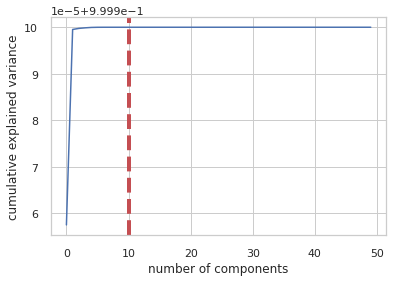

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.999957,9.999575e-01
1,1.000000,4.202703e-05
2,1.000000,2.300699e-07
3,1.000000,1.195964e-07
4,1.000000,8.889667e-08
5,1.000000,3.245943e-08
6,1.000000,6.158326e-09
7,1.000000,2.856091e-10
8,1.000000,1.792736e-10
9,1.000000,1.370520e-10


In [ ]:
pca_test = PCA(n_components=50)
dm_data = pca_test.fit_transform(encoded_data)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())

evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)

pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

### Isolation Forest

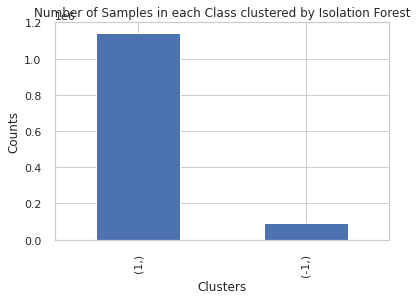

In [ ]:
iForest = IsolationForest(n_estimators=150, random_state=10)
iForest_preds = label_data(iForest, "Isolation Forest", encoded_data)

In [ ]:
np.unique(iForest_preds, return_counts=True)

(array([-1,  1]), array([  92627, 1143343]))

In [ ]:
# Seperate predictions
iForest_c1 = data.loc[iForest_preds == -1]
iForest_c2 = data.loc[iForest_preds == 1]
iForest_c1.shape, iForest_c2.shape

((92627, 22), (1143343, 22))

### Kmeans

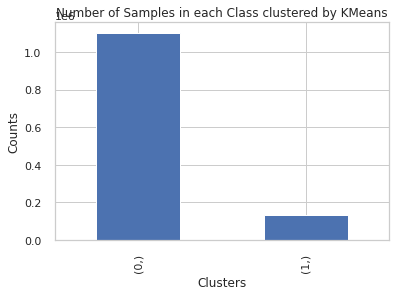

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=10)
kmeans_preds = label_data(kmeans, "KMeans", encoded_data)

In [ ]:
kmeans_c1 = data.loc[kmeans_preds == 0]
kmeans_c2 = data.loc[kmeans_preds == 1]
# kmeans_c3 = data.loc[kmeans_preds == 2]
kmeans_c1.shape, kmeans_c2.shape#, kmeans_c3.shape

((1103256, 22), (132714, 22))

## Evaluation
Let's see how distinguishable the predicted clusters are!?


In [ ]:
# Give the precentage of True values of a column
def percentage(data, label):
  return (len(data.loc[data[label] == True]) / data[label].count()) * 100

In [ ]:
def report(c1, c2):
  """
  Return a reports of clusters to represnt their differences.
  """
  print("Clusters Report")
  print("\t\t\t\t Cluster-1 \t | \t Cluster-2 \n {0}".format("-"*70))
  print('Length Of Cluster:  | \t\t {0} \t\t | \t {1}\n'.format(c1.shape[0], c2.shape[0]))
  print('Robot Percentage:   | \t {0} \t | \t {1}'.format(percentage(c1, 'isBot'), percentage(c2, 'isBot')))
  print('HEAD requestes:     | \t {0} \t | \t {1}'.format(percentage(c1, 'isHEAD'), percentage(c2, 'isHEAD')))
  print('Errors:             | \t {0} \t | \t {1}'.format(percentage(c1, 'ErrorCode'), percentage(c2, 'ErrorCode')))
  print('Robot.Txt:          | \t {0} \t | \t {1}'.format(percentage(c1, 'robotTxt'), percentage(c2, 'robotTxt')))
  print('Image Requests:     | \t {0} \t | \t {1}'.format(percentage(c1, 'isImage'), percentage(c2, 'isImage')))
  print('Avg Request Counts: | \t {0} \t | \t {1}'.format(c1['CountOfRequest'].mean(), c2['CountOfRequest'].mean()))
  print('Avg Time Interval:  | \t {0} \t | \t {1}'.format(np.mean(c1.groupby('UserAgent')['DistanceTime'].mean()), np.mean(c2.groupby('UserAgent')['DistanceTime'].mean())))


### Kmeans-Evaluation

It's got a tolerable result with encoded_data_v2 and the below edditions

In [ ]:
# # encoded_data['PercentOfImages'] = (data.groupby('User')['isImage'].transform(np.count_nonzero) / data['CountOfRequest']) * 100
encoded_data['PercentOfrobotsTxt'] = (data.groupby('User')['robotTxt'].transform(np.count_nonzero) / data['CountOfRequest']) * 100
# # encoded_data['PercentOfHeads'] = (data.groupby('User')['isHEAD'].transform(np.count_nonzero) / data['CountOfRequest']) * 100
# # encoded_data['PercentOfHTMLs'] = (data.groupby('User')['isHTML'].transform(np.count_nonzero) / data['CountOfRequest']) * 100
encoded_data['PercentOfErrors'] = (data.groupby('User')['ErrorCode'].transform(np.count_nonzero) / data['CountOfRequest']) * 100

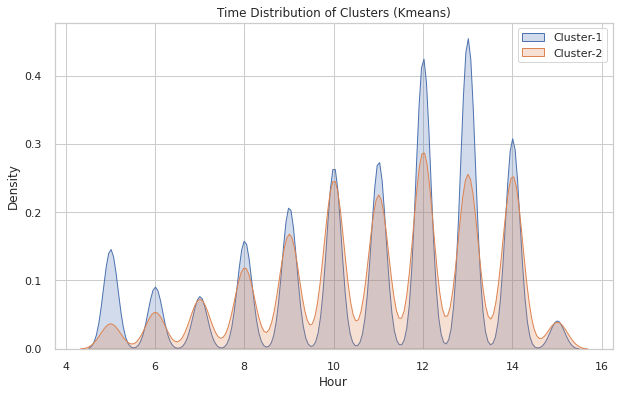

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.kdeplot(kmeans_c1.Hour, shade=True, label="Cluster-1")
ax = sns.kdeplot(kmeans_c2.Hour, shade=True, label="Cluster-2")
# ax = sns.kdeplot(kmeans_c3.Hour, shade=True, label="Cluster-3")
plt.legend()
plt.title("Time Distribution of Clusters (Kmeans)");

In [ ]:
report(kmeans_c1, kmeans_c2)

Clusters Report
				 Cluster-1 	 | 	 Cluster-2 
 ----------------------------------------------------------------------
Length Of Cluster:  | 		 1103256 	 | 	 132714

Robot Percentage:   | 	 6.331168831168831 	 | 	 100.0
HEAD requestes:     | 	 1.7872551792149785 	 | 	 0.0
Errors:             | 	 0.4124156134206385 	 | 	 0.0022605000226050003
Robot.Txt:          | 	 0.01559021659524172 	 | 	 0.0
Image Requests:     | 	 26.28963721928546 	 | 	 6.213361062133611
Avg Request Counts: | 	 12020.080793578281 	 | 	 132714.0
Avg Time Interval:  | 	 4.112148333505466 	 | 	 0.004543605045436051


In [ ]:
user, count = np.unique(kmeans_c1.UserAgent, return_counts=True)
user

In [ ]:
user, count = np.unique(kmeans_c2.UserAgent, return_counts=True)
user

In [ ]:
kmeans_c2.loc[kmeans_c2.UserAgent.str.contains("python-requests/2.18.1")]

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2,Browser,OS,Device,isBot,isImage,robotTxt,isHEAD,ErrorCode,TimeMin,DistanceTime,CountOfRequest


In [ ]:
kmeans_c2.loc[kmeans_c2.UserAgent.str.contains("Python-urllib/3.7")]

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2,Browser,OS,Device,isBot,isImage,robotTxt,isHEAD,ErrorCode,TimeMin,DistanceTime,CountOfRequest


In [ ]:
kmeans_c2.loc[kmeans_c2.UserAgent.str.contains("BlackBerry")]

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2,Browser,OS,Device,isBot,isImage,robotTxt,isHEAD,ErrorCode,TimeMin,DistanceTime,CountOfRequest


### Isolation Forest - Evaluation

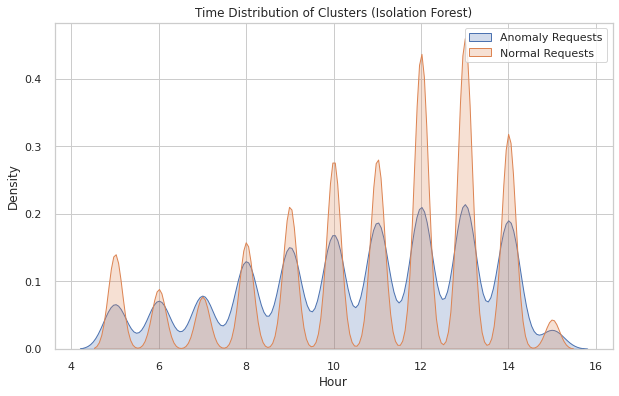

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.kdeplot(iForest_c1.Hour, shade=True, label="Anomaly Requests")
ax = sns.kdeplot(iForest_c2.Hour, shade=True, label="Normal Requests")
plt.legend()
plt.title("Time Distribution of Clusters (Isolation Forest)");

In [ ]:
report(iForest_c1, iForest_c2)

Clusters Report
				 Cluster-1 	 | 	 Cluster-2 
 ----------------------------------------------------------------------
Length Of Cluster:  | 		 92627 		 | 	 1143343

Robot Percentage:   | 	 21.094281365044747 	 | 	 16.007794686283994
HEAD requestes:     | 	 21.281051961091258 	 | 	 0.0005247769042185941
Errors:             | 	 3.416930268712146 	 | 	 0.12139839050923477
Robot.Txt:          | 	 0.03670635991665497 	 | 	 0.012069868797027664
Image Requests:     | 	 16.9237911192201 	 | 	 24.71804174250422
Avg Request Counts: | 	 35346.53471450009 	 | 	 24139.902532310953
Avg Time Interval:  | 	 43.48833204234842 	 | 	 3.737422001935498


In [ ]:
report(iForest_c1, iForest_c2)

Clusters Report
				 Cluster-1 	 | 	 Cluster-2 
 ----------------------------------------------------------------------
Length Of Cluster:  | 		 92201 	 | 	 1143769

Robot Percentage:   | 	 21.125584321211267 	 | 	 16.007165782601206
HEAD requestes:     | 	 21.379377664016662 	 | 	 0.0005245814495759196
Errors:             | 	 3.8470298586783227 	 | 	 0.08795482304556253
Robot.Txt:          | 	 0.03470678192210497 	 | 	 0.012240233823438126
Image Requests:     | 	 15.629982321232957 	 | 	 24.819434693543887
Avg Request Counts: | 	 35460.836737128666 	 | 	 24134.8624101545
Avg Time Interval:  | 	 48.316703845861085 	 | 	 3.7851361541968735


In [ ]:
user, count = np.unique(iForest_c1.UserAgent, return_counts=True)
user

array(['AdsBot-Google (+http://www.google.com/adsbot.html)',
       'AdsTxtCrawler/1.0; +https://github.com/InteractiveAdvertisingBureau/adstxtcrawler',
       'Chrome Privacy Preserving Prefetch Proxy', ..., 'okhttp/3.11.0',
       'okhttp/3.12.1', 'sentry/21.4.1 (https://sentry.io)'], dtype=object)

In [ ]:
user, count = np.unique(iForest_c2.UserAgent, return_counts=True)
user

array(['AdsBot-Google (+http://www.google.com/adsbot.html)',
       'Aloha/2 CFNetwork/1209 Darwin/20.2.0',
       'AlohaBrowser/3.1.5 (iPhone; iOS 14.3; Scale/3.00)', ...,
       'python-requests/2.18.1', 'python-requests/2.25.1',
       'sentry/21.4.1 (https://sentry.io)'], dtype=object)

In [ ]:
iForest_c1.loc[iForest_c1.UserAgent.str.contains("python-requests/2.18.1")]

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2,Browser,OS,Device,isBot,isImage,robotTxt,isHEAD,ErrorCode,TimeMin,DistanceTime,CountOfRequest


In [ ]:
iForest_c1.loc[iForest_c1.UserAgent.str.contains("Python-urllib/3.7")]

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2,Browser,OS,Device,isBot,isImage,robotTxt,isHEAD,ErrorCode,TimeMin,DistanceTime,CountOfRequest


In [ ]:
iForest_c1.loc[iForest_c1.UserAgent.str.contains("BlackBerry")].shape[0]

89

### PCA

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(encoded_data)

In [ ]:
# Plot data
pca = PCA(n_components=2, random_state=10)

data_pca = pca.fit_transform(scaled_data)
data_pca = pd.DataFrame(data=data_pca, index=data.index, columns=['pca-one', 'pca-two'])

In [ ]:
pca.explained_variance_ratio_

array([0.0847913 , 0.07371381])

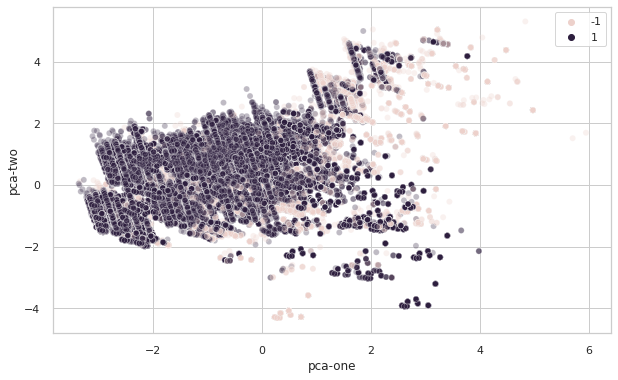

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue= iForest_preds,
    # palette=sns.color_palette("hls", 10),
    data=data_pca,
    legend="full",
    alpha=0.3
);

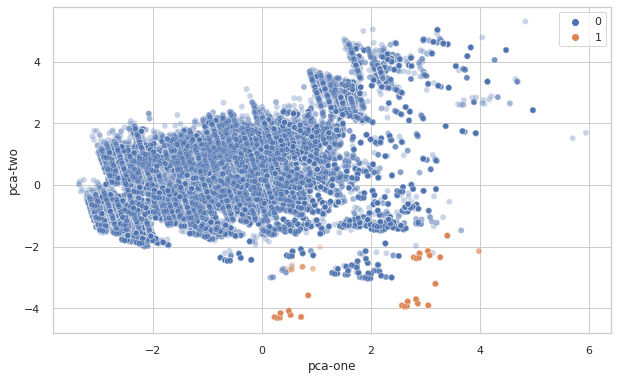

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue= kmeans_preds,
    # palette=sns.color_palette("hls", 10),
    data=data_pca,
    legend="full",
    alpha=0.3
);